# Two-layer Neural Network Workbook for CS145 Homework 3

----
<span style="color:red">**PRINT YOUR NAME AND UID HERE!**</span>

NAME: [Wong, Kai] UID: [704451679]

----


Please follow the notebook linearly to implement a two layer neural network.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a two layer neural network.

---

Import libraries and define relative error function, which is used to check results later. 

In [1]:
import random
import numpy as np
from cs145.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass.

In [2]:
from lib.neural_net import TwoLayerNet

In [3]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Compute forward pass scores

In [4]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.381231204052648e-08


### Forward pass loss

The total loss includes data loss (MSE) and regularization loss, which is,

$$L = L_{data}+L_{reg} = \frac{1}{2N}\sum_{i=1}^{N}\left(\boldsymbol{y}_{\text{pred}}-\boldsymbol{y}_{\text{target}}\right)^2 + \frac{\lambda}{2} \left(||W_1||^2 + ||W_2||^2 \right)$$

More specifically in multi-class situation, if the output of neural nets from one sample is $y_{\text{pred}}=(0.1,0.1,0.8)$ and $y_{\text{target}}=(0,0,1)$ from the given label, then the MSE error will be $Error=(0.1-0)^2+(0.1-0)^2+(0.8-1)^2=0.06$

Implement data loss and regularization loss. In the MSE function, you also need to return the gradients which need to be passed backward. This is similar to batch gradient in linear regression. Test your implementation of loss functions. The Difference should be less than 1e-12.

In [5]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss_MSE = 1.8973332763705641 # check this number

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss_MSE)))

Difference between your loss and correct loss:
0.0


### Backward pass (You do not need to implemented this part)

We have already implemented the backwards pass of the neural network for you.  Run the block of code to check your gradients with the gradient check utilities provided. The results should be automatically correct (tiny relative error).

If there is a gradient error larger than 1e-8, the training for neural networks later will be negatively affected.

In [6]:
from cs145.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 6.774278173332322e-11
b2 max relative error: 1.887502392114964e-11
W1 max relative error: 1.7476665046687833e-09
b1 max relative error: 7.382451041178829e-10


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the linear regression.

Final training loss:  0.02950555626206818


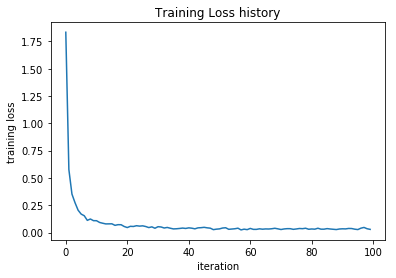

In [7]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [8]:
from cs145.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cs145/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 15-18%.

In [9]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-5, learning_rate_decay=0.95,
            reg=0.1, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 0.5000623457905099
iteration 100 / 1000: loss 0.49982465294352774
iteration 200 / 1000: loss 0.4995946718475304
iteration 300 / 1000: loss 0.49933536166627984
iteration 400 / 1000: loss 0.4989962372581251
iteration 500 / 1000: loss 0.49847178744773624
iteration 600 / 1000: loss 0.4975892783053025
iteration 700 / 1000: loss 0.4966248113033766
iteration 800 / 1000: loss 0.4958001901438695
iteration 900 / 1000: loss 0.49395834359111623
Validation accuracy:  0.172


In [10]:
stats['train_acc_history']

[0.09, 0.15, 0.225, 0.195, 0.225]

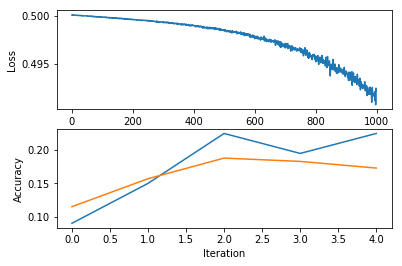

In [11]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()

### Questions:

The training accuracy isn't great. It seems even worse than simple KNN model, which is not as good as expected.

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?

### Answers:
(1): From the above charts, it appears that our model's loss is decreasing at a relatively slow (almost linear) rate during training which may be indicative of too small of a learning rate being used during training. In addition, we see that the accuracy starts to fall off (almost in tandem for both training and validation accuracies) after a certain number of iterations which may indicate that our model is not expressive/large enough for the dataset. This is also a characteristic indicator for high bias which gives rise to underfitting and could be caused by poorly selected regularization parameters or training data with high variance. This could also explain the increasing deviation between training and validation accuracies towards the end of training.

(2): To address the issue of possibly too small a learning rate, we can experiment with using larger learning rates during training or increasing the number of training epochs. For the lack to expressiveness, we could increase the number of hidden layers of the model. However, doing so runs the risk of having too large a model for the dataset which would make it more likely for the model to overfit. For high bias, experimenting with different (likely smaller) regularization strengths may produce better results.

---

## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net.

In [13]:
best_net = None # store the best model into this 

# ================================================================ #
# YOUR CODE HERE:
#   Optimize over your hyperparameters to arrive at the best neural
#   network.  You should be able to get over 45% validation accuracy.
#   For this part of the notebook, we will give credit based on the
#   accuracy you get.  Your score on this question will be multiplied by:
#      min(floor((X - 23%)) / %22, 1) 
#   where if you get 50% or higher validation accuracy, you get full
#   points.
#
#   Note, you need to use the same network structure (keep hidden_size = 50)!
# ================================================================ #

# todo: optimal parameter search (you can use grid search by for-loops )

input_size = 32 * 32 * 3 # do not change
hidden_size = 50 # do not change
num_classes = 10 # do not change
best_valacc = 0 # do not change

# Train the network and find best parameter: 
results = {} # Maps model configs to accuracy values
best_config = ()

for i in range(20):
    print("Trying configuration {0} of {1}".format(i, 20))
    
    # Initialize new hyperparameters
    training_iters = 5000
    # Sample lr and reg over exponential distribution
    lr = np.exp(np.random.uniform(np.log(1e-4), np.log(8e-3)))
    reg = np.exp(np.random.uniform(np.log(1e-3), np.log(8e-3)))
    
    net = TwoLayerNet(input_size, hidden_size, num_classes)

    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=training_iters, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)
    
    config = (lr, reg) 
    train_acc = np.max(stats['train_acc_history'])
    val_acc = np.max(stats['val_acc_history'])
    
    results[config] = (train_acc, val_acc)
    
    if best_valacc < val_acc:
        best_net = net
        best_valacc = val_acc
        best_config = config
        print('New optima found, config: {0}, train acc: {1}, val acc: {2}'.format(config, train_acc, val_acc))

# Output your results
print("== Best parameter settings ==")
print(best_config)
# print your best parameter setting here!
print("Best accuracy on validation set: {}".format(best_valacc))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

Trying configuration 0 of 20
New optima found, config: (0.00018117363153574015, 0.0034999632705506206), train acc: 0.5, val acc: 0.474
Trying configuration 1 of 20
New optima found, config: (0.002513418322989855, 0.0034761687509859292), train acc: 0.685, val acc: 0.496
Trying configuration 2 of 20
Trying configuration 3 of 20
New optima found, config: (0.0007077990883379713, 0.005017412597937231), train acc: 0.62, val acc: 0.5
Trying configuration 4 of 20
Trying configuration 5 of 20
New optima found, config: (0.001198318230738296, 0.0021675793565606467), train acc: 0.68, val acc: 0.505
Trying configuration 6 of 20
New optima found, config: (0.0024903195156529825, 0.0030397047125467376), train acc: 0.67, val acc: 0.507
Trying configuration 7 of 20
Trying configuration 8 of 20
Trying configuration 9 of 20
Trying configuration 10 of 20
Trying configuration 11 of 20
Trying configuration 12 of 20
Trying configuration 13 of 20
Trying configuration 14 of 20
Trying configuration 15 of 20
New 

### Quesions

(1) What is your best parameter settings? (Output from the previous cell)

(2) What parameters did you tune? How are they changing the performance of nerural network? You can discuss any observations from the optimization.

### Answers
(1): Learning Rate: 0.0010024260185475201, Regularization Strength: 0.0028360805471227247. These settings gave a validation accuracy of 51.1%. 

(2): I tuned for learning rate and regularization strength. I also increased the number of training epochs to 5000 to give the model more time to converge to better optima. As discussed earlier, the slow decrease in training loss for the untuned model may have been because of too small a learning rate. Experimenting with different and larger learning rates could therefore help the model converge more quickly during training. The poor accuracy (we even saw a decrease after a number of training iterations) could also have been caused by poor regularization parameters (the regularization strength could have been too large which caused the model to underfit), hence using smaller regularization strengths could strike a better balance of suppressing noisy data without introducing overly large biases that would adversely affect both the model's training and validation accuracies.

---

## Visualize the weights of your neural networks

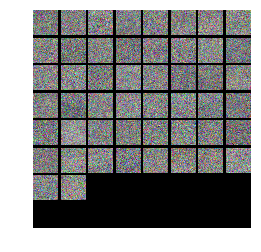

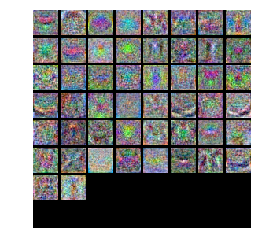

In [14]:
from cs145.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

### Questions:

What differences do you see in the weights between the suboptimal net and the best net you arrived at? What do the weights in neural networks probably learn after training?

### Answer:
The weights of the suboptimal net look a lot more like they are picking up noise compared to those of the best net which appear to have learned certain patterns. In theory, this is what we expect neural networks to do during training that is to learn features of the training data via updating its weights over training iterations. Intuitively, across the layers of a deep neural net (in the context of image recognition like CIFAR-10), shallower layers tend to learn smaller subfeatures of the training data like parts of edges, curves, or other simple patterns and the subsequent deeper layers progressively use these learned subfeatures to construct and learn higher order features of the data set such as a noses, ears, and even faces. Essentially, the neural net can learn features at different levels of abstraction across its layers. 

---

## Evaluate on test set 

In [19]:
test_acc = (best_net.predict(X_test) == y_test).mean()
#test_acc = (subopt_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.478


### Questions:
(1) What is your test accuracy by using the best NN you have got? How much does the performance increase compared with kNN? Why can neural networks perform better than kNN?

(2) Do you have any other ideas or suggestions to further improve the performance of neural networks other than the parameters you have tried in the homework? 

### Answers:
(1): The test accuracy I achieved was 47.8%. This was significantly better (19.6% improvement) than the kNN which had a best accuracy of 28.2% even after some optimizations. Neural networks are much more powerful than kNNs and thus can vastly outperform them on more complex, feature-dense data sets like CIFAR-10. In addition, distance based learning used in kNNs may not be well-suited for image data since it would be difficult to determine the optimum similarity metric and what attributes/features to apply it on. 

(2): There are many ways to further improve the neural network. For instance, we could try using larger neural nets by introducing more hidden layers. To deal with the issue of overfitting due to more layers, we can apply additional regularization techniques such as dropouts. We could also introduce adaptive learning rates to further improve the efficiency of the training process instead of randomly sampling different combinations of parameters and testing them out. However, the most significant improvements would come from using different CNN architectures altogether since a shallow, fully connected net may not be the most ideal for the CIFAR-10 dataset. We could use heavier models that utilize residual/inception/incep-res modules like VGGs, ResNets, or GoogleNets, or we could even just consider using Efficient Neural Architectural Search.

---

## Bonus Question: Change MSE Loss to Cross Entropy Loss

This is a bonus question. If you finish this (cross entropy loss) correctly, you will get **up to 20 points** (add up to your HW3 score). 

Note: From grading policy of this course, your maximum points from homework are still 25 out of 100, but you can use the bonus question to make up other deduction of other assignments.

Pass output scores in networks from forward pass into softmax function. The softmax function is defined as,
$$p_j = \sigma(z_j) = \frac{e^{z_j}}{\sum_{c=1}^{C} e^{z_c}}$$
After softmax, the scores can be considered as probability of $j$-th class.

The cross entropy loss is defined as,
$$L = L_{\text{CE}}+L_{reg} = \frac{1}{N}\sum_{i=1}^{N} \log \left(p_{i,j}\right)+ \frac{\lambda}{2} \left(||W_1||^2 + ||W_2||^2 \right)$$

To take derivative of this loss, you will get the gradient as,
$$\frac{\partial L_{\text{CE}}}{\partial o_i} = p_i - y_i $$

More details about multi-class cross entropy loss, please check [http://cs231n.github.io/linear-classify/](http://cs231n.github.io/linear-classify/) and [more explanation](https://deepnotes.io/softmax-crossentropy) about the derivative of cross entropy.

Change the loss from MSE to cross entropy, you only need to change you ```MSE_loss(x,y)``` in ```TwoLayerNet.loss()``` function to ```softmax_loss(x,y)```.

**Now you are free to use any code to show your results of the two-layer networks with newly-implemented cross entropy loss. You can use code from previous cells.**

In [20]:
# Start training your networks and show your results

In [30]:
# Perform parameter search for neural net using cross entropy loss
best_valacc = 0 # do not change

# Train the network and find best parameter: 
results = {} # Maps model configs to accuracy values
best_config = ()

for i in range(10):
    print("Trying configuration {0} of {1}".format(i, 10))
    
    # Initialize new hyperparameters
    training_iters = 5000
    # Sample lr and reg over exponential distribution
    lr = np.exp(np.random.uniform(np.log(1e-4), np.log(8e-3)))
    reg = np.exp(np.random.uniform(np.log(1e-3), np.log(8e-3)))
    
    net = TwoLayerNet(input_size, hidden_size, num_classes)

    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=training_iters, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)
    
    config = (lr, reg) 
    train_acc = np.max(stats['train_acc_history'])
    val_acc = np.max(stats['val_acc_history'])
    
    results[config] = (train_acc, val_acc)
    
    if best_valacc < val_acc:
        bonus_net = net
        best_valacc = val_acc
        best_config = config
        print('New optima found, config: {0}, train acc: {1}, val acc: {2}'.format(config, train_acc, val_acc))

# Output your results
print("Best parameter settings: {}".format(best_config))
print("Best accuracy on validation set: {}".format(best_valacc))

Trying configuration 0 of 10
New optima found, config: (0.0060727951753900165, 0.0012323838218361244), train acc: 0.255, val acc: 0.188
Trying configuration 1 of 10
New optima found, config: (0.0016498673057145001, 0.0017606055235763628), train acc: 0.725, val acc: 0.521
Trying configuration 2 of 10
New optima found, config: (0.002690354302461906, 0.004950777829091299), train acc: 0.765, val acc: 0.522
Trying configuration 3 of 10
Trying configuration 4 of 10
Trying configuration 5 of 10
Trying configuration 6 of 10
New optima found, config: (0.0006574010963621524, 0.007386784840064884), train acc: 0.68, val acc: 0.532
Trying configuration 7 of 10
Trying configuration 8 of 10
Trying configuration 9 of 10
Best parameter settings: (0.0006574010963621524, 0.007386784840064884)
Best accuracy on validation set: 0.532


In [31]:
# Print training loss of best bonus network
print("\nTraining loss of optimized bonus net:")
bonus_stats = bonus_net.train(X_train, y_train, X_val, y_val,
            num_iters=training_iters, batch_size=200,
            learning_rate=best_config[0], learning_rate_decay=0.95,
            reg=best_config[1], verbose=True)

test_acc = (bonus_net.predict(X_test) == y_test).mean()
print('\nTest accuracy of optimized bonus net: ', test_acc)


Training loss of optimized bonus net:
iteration 0 / 5000: loss 1.2804543631025809
iteration 100 / 5000: loss 1.345756189465466
iteration 200 / 5000: loss 1.2999990039535678
iteration 300 / 5000: loss 1.3373089892774532
iteration 400 / 5000: loss 1.3803984545757333
iteration 500 / 5000: loss 1.266307716454835
iteration 600 / 5000: loss 1.2295290055837567
iteration 700 / 5000: loss 1.3109857107274183
iteration 800 / 5000: loss 1.3279069900217388
iteration 900 / 5000: loss 1.2165281383646807
iteration 1000 / 5000: loss 1.2387567594643778
iteration 1100 / 5000: loss 1.2577608272883225
iteration 1200 / 5000: loss 1.1627396011666165
iteration 1300 / 5000: loss 1.1957698286474032
iteration 1400 / 5000: loss 1.2246116799962103
iteration 1500 / 5000: loss 1.1914610866442392
iteration 1600 / 5000: loss 1.2644648156058382
iteration 1700 / 5000: loss 1.304905705094543
iteration 1800 / 5000: loss 1.196028127261865
iteration 1900 / 5000: loss 1.209218665986471
iteration 2000 / 5000: loss 1.13668762

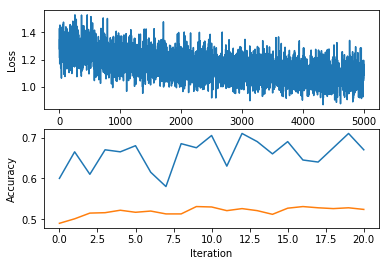

In [32]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(bonus_stats['loss_history'])
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(bonus_stats['train_acc_history'], label='train')
plt.plot(bonus_stats['val_acc_history'], label='val')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()